In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

###  MicroGrad demo

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [4]:
np.random.seed(1337)
random.seed(1337)

[1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0]


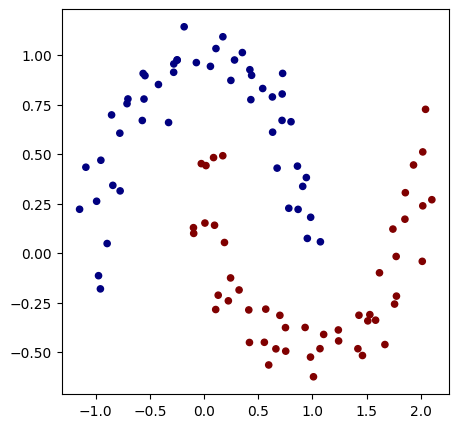

In [2]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = ((y*2 - 1) > 0).astype(int) # make y be 0 or 1
print(y)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [ ]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

In [ ]:
a= Value(2.0)
b = Value(-3.0)
a + b 

entered here


Value(data=-1.0, grad=0)

In [ ]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.3113255221276805, grad=0) 0.46


In [ ]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


(-1.548639298268643, 1.951360701731357)

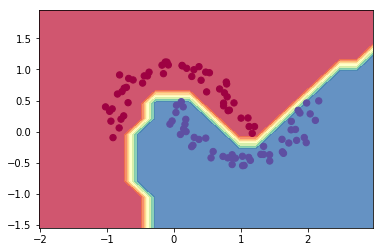

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


## trying his data with my model

In [3]:
from macrograd.engine import Tensor
from macrograd.nn import MLP_macro

In [4]:
model = MLP_macro(2, [16, 16, 2]) # 2-layer neural network


In [5]:
def softmax_loss(scores, y, stabalize=False, alpha=0):
    m = len(y.array)
    Z = scores
    if stabalize:
        Z = Tensor(Z.array - np.max(Z.array, axis = 1, keepdims=True))
    exp_Z = Z.exp()
    # exp_Z = (16, 2)
    # previous implementation broke down here. Could not do (16, 1) --> (16, 2). Went to (16, 16) instead. 
    softmax_probs = exp_Z / exp_Z.summation(axes=(1,)).reshape((exp_Z.array.shape[0], 1)).BroadcastTo((exp_Z.array.shape))
    
    # one hot encode y
    y_a = y.array
    num_classes = scores.array.shape[1]
    y_one_hot_encoding = np.zeros((y_a.shape[0], num_classes))
    y_one_hot_encoding[np.arange(y_a.shape[0]), y_a.flatten()] = 1
    
    log_t = softmax_probs.log() * Tensor(y_one_hot_encoding)
    loss = - log_t.summation(axes=None) / m

    if alpha != 0:
        reg_loss = alpha * sum([(p.array*p.array).sum() for p in model.parameters()])
        loss += reg_loss

    preds = np.argmax(softmax_probs.array, axis=1)
    accuracy = np.sum(y.array.flatten() == preds) / m

    return loss, accuracy


# def loss(X_batch, y_batch):
#     # forward the model to get probs
#     scores = model(X_batch)
#     # get the predicted classes

#     losses, softmax_probs = scores.cross_entropy_loss(X_batch, y_batch, stabalize=True)

    
#     # L2 regularization
#     # alpha = 1e-4
#     # reg_loss = alpha * sum([(p.array*p.array).sum() for p in model.parameters()])
#     total_loss = losses # +  Tensor(reg_loss)
    
#     # also get accuracy
#     m = len(y_batch.array)
#     preds = np.argmax(softmax_probs, axis=1)
#     accuracy = np.sum(y_batch.array.flatten() == preds) / m
#     return total_loss, accuracy


In [6]:
def train(X, y, epochs=60, batch_size=None):
    for k in range(epochs):
        if batch_size is None:
            X_batch, y_batch = X, y
        else:
            ri = np.random.permutation(X.shape[0])[:batch_size]
            X_batch, y_batch = X[ri], y[ri]
        inputs = Tensor(np.array([xrow for xrow in X_batch]))
        y_batch = Tensor(np.array(y_batch).reshape(-1, 1))

        # print(f"{inputs.array.shape = }")
        # print(f"{y_batch.array.shape = }")

        # forward the model to get scores
        scores = model(inputs)
        # forward
        total_loss, acc = softmax_loss(scores, y_batch)
        
        # backward
        model.zero_grad()
        total_loss.backward()

        # update (sgd)
        # finetune the learning rate. harcoded decay: at step 30, decreasee the lr. at step 70 decrease lr. 
        # this way you force the model to local minimum
        learning_rate = 0.001
        for p in model.parameters():
            # print(f"{np.linalg.norm(p.grad) = }")
            if batch_size is not None:
                p.array -= learning_rate * 1/ batch_size * p.grad
            else:
                p.array -= learning_rate * p.grad
        
        if k % 10 == 0:
            # preds = np.argmax(scores.array, axis = 1)
            # print(f"preds are {preds.reshape(1, -1)}, should be {y_batch.array.reshape(1, -1)}")
            print(f"step {k} loss {total_loss.array}, accuracy {acc*100}%")
train(X, y, 600)
# don't use batching. 

step 0 loss 0.9930026433649164, accuracy 43.0%
step 10 loss 0.9702369225184967, accuracy 43.0%
step 20 loss 0.9485895380323618, accuracy 42.0%
step 30 loss 0.927917085133669, accuracy 42.0%
step 40 loss 0.9082048324515738, accuracy 42.0%
step 50 loss 0.8895164730208793, accuracy 44.0%
step 60 loss 0.8717405799461659, accuracy 44.0%
step 70 loss 0.854931353268874, accuracy 43.0%
step 80 loss 0.8388934448286526, accuracy 43.0%
step 90 loss 0.823547315917906, accuracy 43.0%
step 100 loss 0.808811387571889, accuracy 44.0%
step 110 loss 0.7947058190514712, accuracy 44.0%
step 120 loss 0.7811897945676032, accuracy 44.0%
step 130 loss 0.7683472497889565, accuracy 46.0%
step 140 loss 0.7560325923562229, accuracy 47.0%
step 150 loss 0.7442231516215848, accuracy 50.0%
step 160 loss 0.7328901173728564, accuracy 50.0%
step 170 loss 0.7221324920694636, accuracy 53.0%
step 180 loss 0.7118564077391147, accuracy 54.0%
step 190 loss 0.7020981816459378, accuracy 54.0%
step 200 loss 0.6927376200355962, a

even got it up to 90% at one point.

not good when I train with batch_size:

In [8]:
train(X, y, 600, 16)

step 0 loss 0.4249596976621097, accuracy 81.25%
step 10 loss 0.34215942836594965, accuracy 87.5%
step 20 loss 0.3903201366510721, accuracy 87.5%
step 30 loss 0.47411860166566777, accuracy 68.75%
step 40 loss 0.3733655189167622, accuracy 93.75%
step 50 loss 0.3880498851704569, accuracy 81.25%
step 60 loss 0.4434166098442578, accuracy 81.25%
step 70 loss 0.4494777666184608, accuracy 75.0%
step 80 loss 0.4153052980858753, accuracy 81.25%
step 90 loss 0.4900498893355007, accuracy 75.0%
step 100 loss 0.4887571566380878, accuracy 81.25%
step 110 loss 0.4719822779669812, accuracy 75.0%
step 120 loss 0.3840903655412632, accuracy 81.25%
step 130 loss 0.3530548370923289, accuracy 87.5%
step 140 loss 0.42068026447351514, accuracy 81.25%
step 150 loss 0.3058367922838152, accuracy 100.0%
step 160 loss 0.3115240569381653, accuracy 93.75%
step 170 loss 0.3957895612407493, accuracy 87.5%
step 180 loss 0.36733346781274095, accuracy 100.0%
step 190 loss 0.3239583716048824, accuracy 93.75%
step 200 loss 

The accuracy is all over the place. 

# MNIST with macrograd

In [9]:
# don't even use pytorch

import torch  # install pytorch and then download MNIST
from torchvision import datasets, transforms

# transform example said to do: https://github.com/pytorch/examples/blob/main/mnist/main.py#L7
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [13]:
# flatten the images
def flatten_images(images_array):
    prod = 1
    shape_of_arr = list(images_array.shape)
    for i in range(1, len(shape_of_arr)):
        prod *= shape_of_arr[i]
    return images_array.reshape(images_array.shape[0], prod)

mnist_trainset.data = flatten_images(mnist_trainset.data)
mnist_testset.data = flatten_images(mnist_testset.data)

print(f"{len(mnist_trainset) = }")
print(f"{len(mnist_testset) = }")
print(f"{mnist_trainset.data.shape = }")
print(f"{mnist_trainset[0] = }")
print(f"{mnist_trainset.targets[0] = }")
print(f"{mnist_testset.data.shape = }")

b_s = 100

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=b_s, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=b_s, shuffle=False)




len(mnist_trainset) = 60000
len(mnist_testset) = 10000
mnist_trainset.data.shape = torch.Size([60000, 784])
mnist_trainset[0] = (tensor([[[-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-0.4242],
         [-

In [ ]:
print(f"{len(mnist_trainset) = }")
print(f"{len(mnist_testset) = }")
print(f"{mnist_trainset.data.shape = }")  # Shape after flattening
print(f"{mnist_trainset[0] = }")
print(f"{mnist_trainset.targets[0] = }")
print(f"{mnist_testset.data.shape = }")   # Shape after flattening


In [12]:
from macrograd.engine import Tensor
from macrograd.nn import MLP_macro

In [14]:
model_mnist = MLP_macro(28*28, [10, 10, 10]) # 2-layer neural network
# print(model)
# print("number of parameters", len(model.parameters()))

In [15]:
def train(epochs=60, batch_size=None):
    for k in range epochs:
        for images, labels in train_loader:
            X_batch_array = images.numpy()
            X_batch_array = flatten_images(X_batch_array)
            y_batch_array = labels.numpy()
            y_batch_array = flatten_images(y_batch_array)

        X_batch = Tensor(X_batch_array)
        y_batch = Tensor(y_batch_array)

        # forward the model to get scores
        scores = model_mnist(X_batch)
        # forward
        total_loss, acc = softmax_loss(scores, y_batch)
        
        # backward
        model_mnist.zero_grad()
        total_loss.backward()

        # update (sgd)
        # finetune the learning rate. harcoded decay: at step 30, decreasee the lr. at step 70 decrease lr. 
        # this way you force the model to local minimum
        learning_rate = 0.001
        for p in model_mnist.parameters():
            # print(f"{np.linalg.norm(p.grad) = }")
            if batch_size is not None:
                p.array -= learning_rate * 1/ batch_size * p.grad
            else:
                p.array -= learning_rate * p.grad
        
        if k % 10 == 0:
            # preds = np.argmax(scores.array, axis = 1)
            # print(f"preds are {preds.reshape(1, -1)}, should be {y_batch.array.reshape(1, -1)}")
            print(f"step {k} loss {total_loss.array}, accuracy {acc*100}%")
train(epochs=600, batch_size=100)
# don't use batching. 

NameError: name 'k' is not defined